In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wrf import interplevel
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [2]:
# open datasets
orog = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc')['Z']
u = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/u/2020s/e*.nc', combine='nested', concat_dim='time')['U']
v = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/v/2020s/e*.nc', combine='nested', concat_dim='time')['V']
Z = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/Z/2020s/e*.nc', combine='nested', concat_dim='time')['Z']
u10 = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/u10/2020s/e*.nc', combine='nested', concat_dim='time')['VAR_10U']
v10 = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/v10/2020s/e*.nc', combine='nested', concat_dim='time')['VAR_10V']

In [3]:
# Calculate the height AGL
era5_agl = (Z - orog.sel(latitude=slice(50, 23.5)).sel(longitude=slice(234, 295))[0]) / 9.8

In [4]:
# Select MAMJJA only - u10 and v10
u10_mamjja = u10.sel(time=u10.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
v10_mamjja = v10.sel(time=v10.time.dt.month.isin([3, 4, 5, 6, 7, 8]))

In [5]:
# Select only MAMJJA - u and v
u_mamjja = u.sel(time=u.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
v_mamjja = v.sel(time=v.time.dt.month.isin([3, 4, 5, 6, 7, 8]))

In [6]:
# Select only MAMJJA - height AGL
agl_mamjja = era5_agl.sel(time=era5_agl.time.dt.month.isin([3, 4, 5, 6, 7, 8]))

In [7]:
u_6k = np.zeros((len(u_mamjja['time']), len(u_mamjja['latitude']), len(u_mamjja['longitude'])))
v_6k = np.zeros((len(v_mamjja['time']), len(v_mamjja['latitude']), len(v_mamjja['longitude'])))
for i in range(5):
    u_load = u_mamjja.sel(time=u_mamjja.time.dt.year.isin([2020 + i])).load()
    v_load = v_mamjja.sel(time=v_mamjja.time.dt.year.isin([2020 + i])).load()
    agl_load = agl_mamjja.sel(time=agl_mamjja.time.dt.year.isin([2020 + i])).load()

    u_6k[i*184: (i+1)*184] = interplevel(u_load, agl_load, 6000)
    v_6k[i*184: (i+1)*184] = interplevel(v_load, agl_load, 6000)

    print(f'{2020+i} is complete.')

2020 is complete.
2021 is complete.
2022 is complete.
2023 is complete.
2024 is complete.


In [8]:
# Convert to XR
u_6k_xr = xr.DataArray(u_6k, coords={'time':u_mamjja['time'], 'latitude':u_mamjja['latitude'], 'longitude':u_mamjja['longitude']}, dims=['time', 'latitude', 'longitude'])
v_6k_xr = xr.DataArray(v_6k, coords={'time':u_mamjja['time'], 'latitude':u_mamjja['latitude'], 'longitude':u_mamjja['longitude']}, dims=['time', 'latitude', 'longitude'])

In [11]:
# Save
u_6k_xr.to_netcdf('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/u_6k/u_6k_2020s.nc')
v_6k_xr.to_netcdf('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/v_6k/v_6k_2020s.nc')

In [9]:
# Open another decade for comparison
test = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/u_6k/u_6k_1970s.nc')['__xarray_dataarray_variable__']

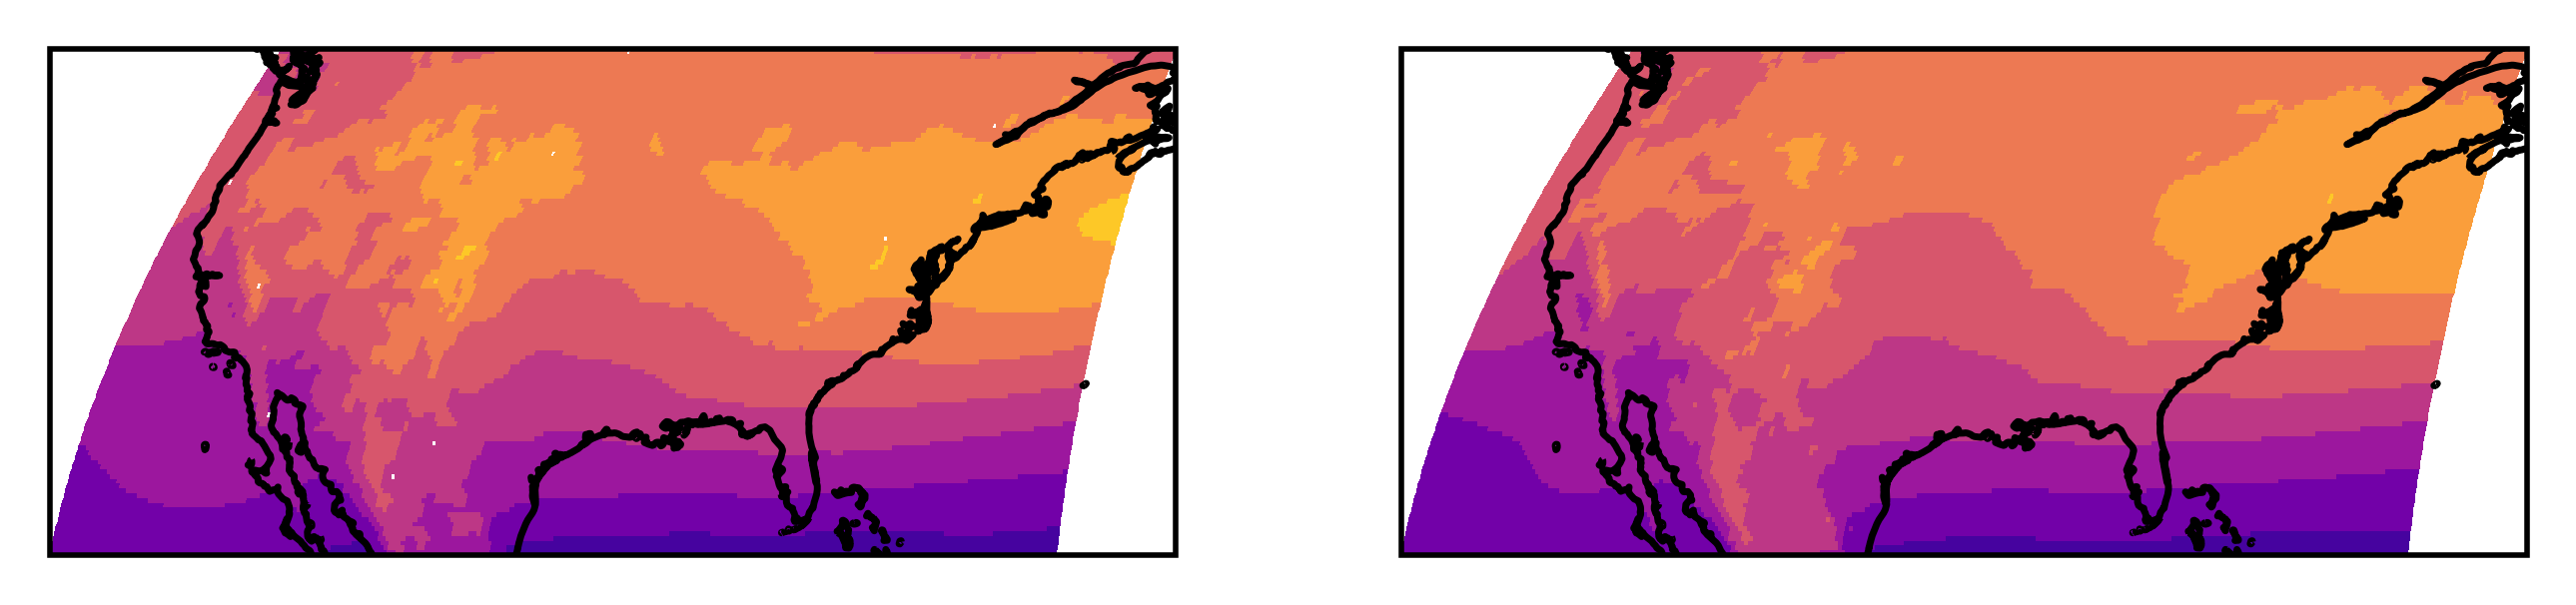

In [10]:
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.Robinson()))

bounds = np.arange(0, 22, 2)

norm = c.BoundaryNorm(bounds, plt.get_cmap('plasma').N)

for i in range(2):
    ax[i].coastlines()

ax[0].pcolormesh(u['longitude'], u['latitude'], np.mean(u_6k, axis=0), transform=ccrs.PlateCarree(), cmap='plasma', norm=norm)
ax[1].pcolormesh(test['longitude'], test['latitude'], test.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='plasma', norm=norm)